# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


In [3]:
input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [4]:
import lasagne
from lasagne.layers import *

#Input layer (auxilary)
l = InputLayer(shape = input_shape,input_var=input_X)
# l2 = DropoutLayer(l1, p=0.2)
# l6 = DenseLayer(l2, num_units=500,nonlinearity = lasagne.nonlinearities.leaky_rectify)
# l6 = DenseLayer(l2, num_units=10,nonlinearity = lasagne.nonlinearities.leaky_rectify

print(l.output_shape)
l = Conv2DLayer(l, num_filters=20, filter_size=(5, 5), nonlinearity=lasagne.nonlinearities.linear, pad = 'same')
print(l.output_shape)
l = MaxPool2DLayer(l, pool_size=(2, 2))
print(l.output_shape)
l = Conv2DLayer(l, num_filters=10, filter_size=(5, 5), nonlinearity=lasagne.nonlinearities.linear, pad = 'same')
print(l.output_shape)
l = MaxPool2DLayer(l, pool_size=(2, 2))
print(l.output_shape)
# l = Conv2DLayer(l, num_filters=10, filter_size=(5, 5), nonlinearity=lasagne.nonlinearities.rectify, pad = 'same')
# print(l.output_shape)
# l = MaxPool2DLayer(l, pool_size=(2, 2))
# print(l.output_shape)
# l5 = DropoutLayer(l4, p=0.5)
# l2 = Pool1DLayer(l1, pool_size=(1,1,16,16))
l = DropoutLayer(l, p=0.6)
l = DenseLayer(l, num_units = 1000,nonlinearity=lasagne.nonlinearities.tanh)

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
l_out = DenseLayer(l, num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)


(None, 1, 28, 28)
(None, 20, 28, 28)
(None, 20, 14, 14)
(None, 10, 14, 14)
(None, 10, 7, 7)


In [5]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(l_out)
y_test_predicted = lasagne.layers.get_output(l_out, deterministic = True)

In [6]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(l_out)
print(all_weights)

[W, b, W, b, W, b, W, b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [7]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_test_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adadelta(loss, all_weights,learning_rate=0.3, rho=0.9)

In [8]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [9]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

In [16]:
import time

num_epochs = 1000 #amount of passes through the data
loss = []
batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    loss.append(train_err / train_batches)

Epoch 1 of 1000 took 70.250s
  training loss (in-iteration):		0.023741
  train accuracy:		99.88 %
  validation accuracy:		99.36 %
Epoch 2 of 1000 took 70.286s
  training loss (in-iteration):		0.022816
  train accuracy:		99.88 %
  validation accuracy:		99.40 %
Epoch 3 of 1000 took 67.706s
  training loss (in-iteration):		0.023069
  train accuracy:		99.89 %
  validation accuracy:		99.35 %
Epoch 4 of 1000 took 72.194s
  training loss (in-iteration):		0.022371
  train accuracy:		99.89 %
  validation accuracy:		99.29 %
Epoch 5 of 1000 took 70.723s
  training loss (in-iteration):		0.023568
  train accuracy:		99.91 %
  validation accuracy:		99.20 %
Epoch 6 of 1000 took 70.749s
  training loss (in-iteration):		0.022585
  train accuracy:		99.88 %
  validation accuracy:		99.37 %
Epoch 7 of 1000 took 71.019s
  training loss (in-iteration):		0.020599
  train accuracy:		99.91 %
  validation accuracy:		99.36 %
Epoch 8 of 1000 took 70.303s
  training loss (in-iteration):		0.020162
  train accuracy:		

Epoch 64 of 1000 took 69.665s
  training loss (in-iteration):		0.012653
  train accuracy:		99.99 %
  validation accuracy:		99.41 %
Epoch 65 of 1000 took 70.901s
  training loss (in-iteration):		0.011929
  train accuracy:		100.00 %
  validation accuracy:		99.46 %
Epoch 66 of 1000 took 70.342s
  training loss (in-iteration):		0.012437
  train accuracy:		99.99 %
  validation accuracy:		99.46 %
Epoch 67 of 1000 took 70.363s
  training loss (in-iteration):		0.011062
  train accuracy:		99.99 %
  validation accuracy:		99.33 %
Epoch 68 of 1000 took 70.647s
  training loss (in-iteration):		0.011197
  train accuracy:		99.99 %
  validation accuracy:		99.44 %
Epoch 69 of 1000 took 70.734s
  training loss (in-iteration):		0.011539
  train accuracy:		99.99 %
  validation accuracy:		99.44 %
Epoch 70 of 1000 took 68.959s
  training loss (in-iteration):		0.011586
  train accuracy:		99.99 %
  validation accuracy:		99.43 %
Epoch 71 of 1000 took 71.485s
  training loss (in-iteration):		0.011423
  train ac

Epoch 127 of 1000 took 71.792s
  training loss (in-iteration):		0.008956
  train accuracy:		100.00 %
  validation accuracy:		99.49 %
Epoch 128 of 1000 took 67.461s
  training loss (in-iteration):		0.008226
  train accuracy:		100.00 %
  validation accuracy:		99.44 %
Epoch 129 of 1000 took 70.935s
  training loss (in-iteration):		0.008576
  train accuracy:		100.00 %
  validation accuracy:		99.46 %
Epoch 130 of 1000 took 68.220s
  training loss (in-iteration):		0.007689
  train accuracy:		100.00 %
  validation accuracy:		99.40 %
Epoch 131 of 1000 took 70.079s
  training loss (in-iteration):		0.009476
  train accuracy:		100.00 %
  validation accuracy:		99.50 %
Epoch 132 of 1000 took 69.512s
  training loss (in-iteration):		0.008405
  train accuracy:		100.00 %
  validation accuracy:		99.41 %
Epoch 133 of 1000 took 70.196s
  training loss (in-iteration):		0.008009
  train accuracy:		100.00 %
  validation accuracy:		99.40 %
Epoch 134 of 1000 took 68.934s
  training loss (in-iteration):		0.008

Epoch 189 of 1000 took 69.789s
  training loss (in-iteration):		0.007454
  train accuracy:		100.00 %
  validation accuracy:		99.43 %
Epoch 190 of 1000 took 69.764s
  training loss (in-iteration):		0.006673
  train accuracy:		100.00 %
  validation accuracy:		99.38 %
Epoch 191 of 1000 took 70.278s
  training loss (in-iteration):		0.007093
  train accuracy:		100.00 %
  validation accuracy:		99.42 %
Epoch 192 of 1000 took 70.451s
  training loss (in-iteration):		0.006578
  train accuracy:		100.00 %
  validation accuracy:		99.41 %
Epoch 193 of 1000 took 71.969s
  training loss (in-iteration):		0.007268
  train accuracy:		100.00 %
  validation accuracy:		99.38 %
Epoch 194 of 1000 took 70.514s
  training loss (in-iteration):		0.006784
  train accuracy:		100.00 %
  validation accuracy:		99.41 %
Epoch 195 of 1000 took 71.154s
  training loss (in-iteration):		0.007185
  train accuracy:		100.00 %
  validation accuracy:		99.42 %
Epoch 196 of 1000 took 67.135s
  training loss (in-iteration):		0.006

Epoch 251 of 1000 took 70.096s
  training loss (in-iteration):		0.005705
  train accuracy:		100.00 %
  validation accuracy:		99.39 %
Epoch 252 of 1000 took 69.434s
  training loss (in-iteration):		0.006112
  train accuracy:		100.00 %
  validation accuracy:		99.44 %
Epoch 253 of 1000 took 68.447s
  training loss (in-iteration):		0.005653
  train accuracy:		100.00 %
  validation accuracy:		99.33 %
Epoch 254 of 1000 took 71.458s
  training loss (in-iteration):		0.007209
  train accuracy:		100.00 %
  validation accuracy:		99.41 %
Epoch 255 of 1000 took 70.690s
  training loss (in-iteration):		0.005535
  train accuracy:		100.00 %
  validation accuracy:		99.43 %
Epoch 256 of 1000 took 71.213s
  training loss (in-iteration):		0.007527
  train accuracy:		100.00 %
  validation accuracy:		99.45 %
Epoch 257 of 1000 took 67.898s
  training loss (in-iteration):		0.004948
  train accuracy:		100.00 %
  validation accuracy:		99.42 %
Epoch 258 of 1000 took 71.150s
  training loss (in-iteration):		0.007

Epoch 313 of 1000 took 68.450s
  training loss (in-iteration):		0.005779
  train accuracy:		100.00 %
  validation accuracy:		99.43 %
Epoch 314 of 1000 took 71.844s
  training loss (in-iteration):		0.005386
  train accuracy:		100.00 %
  validation accuracy:		99.44 %
Epoch 315 of 1000 took 70.485s
  training loss (in-iteration):		0.005540
  train accuracy:		100.00 %
  validation accuracy:		99.47 %
Epoch 316 of 1000 took 68.953s
  training loss (in-iteration):		0.006480
  train accuracy:		100.00 %
  validation accuracy:		99.45 %
Epoch 317 of 1000 took 68.068s
  training loss (in-iteration):		0.005490
  train accuracy:		100.00 %
  validation accuracy:		99.44 %
Epoch 318 of 1000 took 71.986s
  training loss (in-iteration):		0.006539
  train accuracy:		100.00 %
  validation accuracy:		99.39 %
Epoch 319 of 1000 took 71.116s
  training loss (in-iteration):		0.005617
  train accuracy:		100.00 %
  validation accuracy:		99.35 %
Epoch 320 of 1000 took 68.699s
  training loss (in-iteration):		0.006

KeyboardInterrupt: 

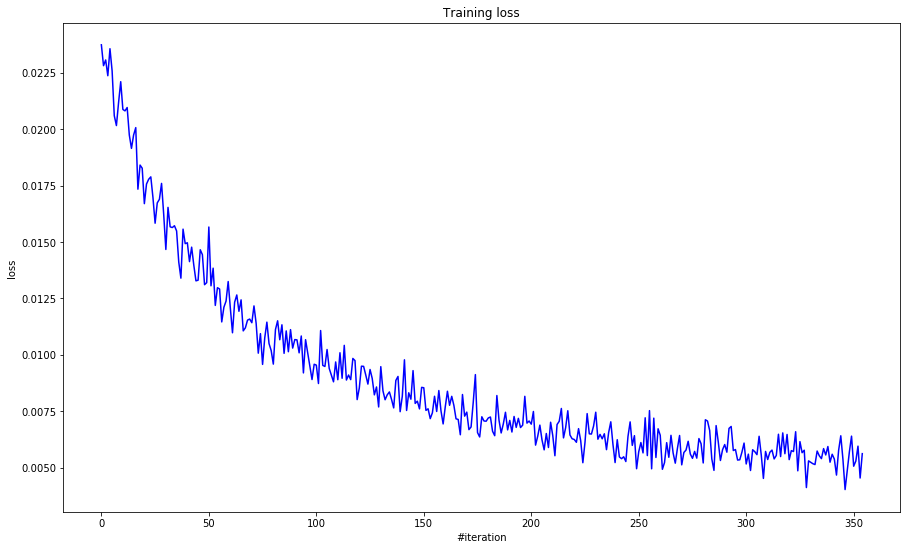

In [17]:
plt.figure(figsize=(15, 9))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss, 'b')
plt.show()

In [18]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
  test accuracy:		99.46 %
Achievement unlocked: 80lvl Warlock!


# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!

It worked around 8 hours for this, but even with 20 minutes test accuracy was 99.25, so I am still 80lvl Warlock now